In [1]:
using PyPlot
using LsqFit
include("mc_julia.jl") ;

In [2]:
include("../compute_ttv.jl")
importall TTVFaster

### 0. Read and plot TTV data 

In [3]:
dat1 = readdlm("../ttv_planet1.txt")
t1 = dat1[:,1]
dat2 = readdlm("../ttv_planet2.txt")
t2 = dat2[:,1];
data = Array{Float64}[t1,t2] ;

In [4]:
p_guesser(time::Array{Float64}) = mean(diff(time))
per_guess1 = p_guesser(t1)
per_guess2 = p_guesser(t2) ;

In [5]:
println(per_guess1,'\n',per_guess2)
# 5. venus and earth!

224.70076641863517
365.25630708152175


In [6]:
reg_transits(period::Float64,t0::Float64,n_trans::Int64) = [t0+period*(i-1) for i=1:n_trans]
#returns regular transit times ;

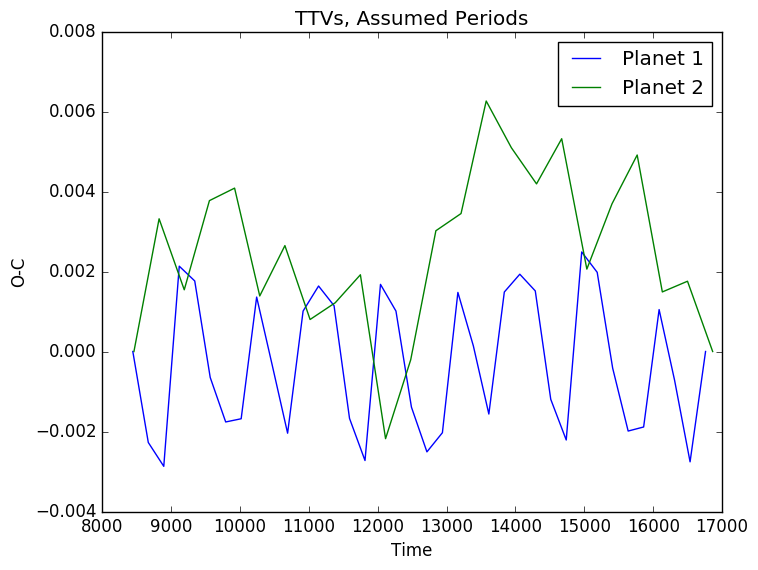

In [7]:
plot(t1,t1-reg_transits(per_guess1,t1[1],length(t1)),label="Planet 1")
plot(t2,t2-reg_transits(per_guess2,t2[1],length(t2)),label="Planet 2")
xlabel("Time")
ylabel("O-C")
title("TTVs, Assumed Periods")
legend(loc=0) ;

### 1. Create a wrapper for compute_ttv.jl which calls N(N-1) pairs of planets to compute the TTV of each planet due to all of the others.

In [8]:
fieldnames(TTVFaster.Planet_plane_hk)

5-element Array{Symbol,1}:
 :mass_ratio
 :period    
 :trans0    
 :ecosw     
 :esinw     

In [9]:
make_plane(m::Float64,p::Float64,t0::Float64,ec::Float64,es::Float64) = Planet_plane_hk(m, p, t0, ec, es)

make_plane (generic function with 1 method)

In [11]:
make_n_trans(data::Array{Array{Float64}}) = Int64[length(time) for time in data]

make_n_trans (generic function with 1 method)

In [17]:
function compute_ttv_pairs(n_p::Int64,n_trans_arr::Array{Int64},jmax::Int64,planets::Array{TTVFaster.Planet_plane_hk{Float64},1})
    
    ttvs = Array{Array{Float64}}(n_p)
    reg_times = Array{Array{Float64}}(n_p)
    n_p_t = length(n_trans_arr)
    
    for i=1:n_p #for all transiting planets, make an array of zero TTVS for each planet, reg times for each planet
        if i<=n_p_t
            ttvs[i] = zeros(n_trans_arr[i])
            reg_times[i] = reg_transits(planets[i].period,planets[i].trans0,n_trans_arr[i])
        else
            ttvs[i] = zeros(maximum(n_trans_arr))
            reg_times[i] = reg_transits(planets[i].period,planets[i].trans0,maximum(n_trans_arr))
        end  
    end
        
    for i=1:n_p-1 #for each planet
        for j=(i+1):n_p #go to each other planet
            time1 = reg_times[i]
            time2 = reg_times[j]
            ttvs1 = zeros(length(time1))
            ttvs2 = zeros(length(time2))
            compute_ttv!(jmax,planets[i],planets[j],time1,time2,ttvs1,ttvs2) #compute ttvs, add to array
            ttvs[i] .+= ttvs1 #add on to the TTVs
            ttvs[j] .+= ttvs2
        end
    end
    
    return (reg_times,ttvs,reg_times.+ttvs)
    
end

compute_ttv_pairs (generic function with 1 method)

### 2. Carry out an initial fit to the transit times of the two planets.

In [18]:
function ttv_model(times::Array{Array{Float64}},p::Array{Float64})
    
    #Apparently we actually get sensible fits when not making sure the parameters make sense
    #for (m,P,Psort,t0,ecos,esin) in zip(p[1:5:end],p[2:5:end],sort(p[2:5:end]),p[3:5:end],p[4:5:end],p[5:5:end])
    #    if (m <= 0.0)|(P <= 0.0)|(P != Psort)|(t0 <= 0.0)|(abs(ecos) >= 1.0)|(abs(esin) >= 1.0)
    #        flag = false
    #    end
    #end
    
   # if (sort(p[2:5:end])== p[2:5:end])&(abs(p[2:5:end])==p[2:5:end]) #Make sure that periods make sense
   #     flag=true
   # end
    
    n_p = length(p[1:5:end])
    n_trans_arr = make_n_trans(times)
    
    #if flag

    #Make planets
    planes = TTVFaster.Planet_plane_hk{Float64}[make_plane(p[1+5*(i-1)],p[2+5*(i-1)],p[3+5*(i-1)],p[4+5*(i-1)],p[5+5*(i-1)]) for i=1:n_p]

    #Compute TTVs
    regs,ttvs,trans_times = compute_ttv_pairs(n_p,n_trans_arr,10,planes)

    #Output linear array of transit times
    lin_out = Float64[]
    for i=1:length(n_trans_arr)
        append!(lin_out,trans_times[i])
    end

    return lin_out #regular transits plus the TTVS
        
    #else
        
    #    return fill(1.0e10,sum(n_trans_arr))
        
    #end
    
end

ttv_model (generic function with 1 method)

In [19]:
function fit_ttvs(times::Array{Array{Float64}}; n_p::Int64 = length(times))
     
    #1D array of times to make fitting easier
    lintimes = Float64[]
    for i=1:length(times)
        append!(lintimes,times[i])
    end
    
    weights = [1.0/(0.000347222^2.0) for i=1:length(lintimes)] #30 second precision
    
    p0 = zeros(5*n_p)
    #initialize params
    #p[1+5(i-1)]-p[5+5(i-1)] = mass_ratio, period, t0, ecosw, esinw for planet i
    for i=1:n_p
        p0[1+5*(i-1)] = 2.0e-6 #this is a terrestrial world hopefully
        p0[2+5*(i-1)] = p_guesser(times[i]) #guess the period
        p0[3+5*(i-1)] = times[i][1] #guess the time of transit
        p0[4+5*(i-1)] = 0.1 #small eccentricities to start with
        p0[5+5*(i-1)] = 0.1
    end
        
    fit = curve_fit(ttv_model,times,lintimes,weights,p0)
    
end

fit_ttvs (generic function with 1 method)

In [20]:
result = fit_ttvs(data) ;

In [21]:
parnames = ["M_1","P_1","t0_1","ecosw_1","esinw_1","M_2","P_2","t0_2","ecosw_2","esinw_2"]
for (nam,par) in zip(parnames,result.param)
    println("$nam = $par")
end

M_1 = 2.235101296215343e-6
P_1 = 224.70077045197777
t0_1 = 8445.49952245744
ecosw_1 = 0.007259046930495344
esinw_1 = 0.0035222482271572565
M_2 = 3.1241996571104925e-6
P_2 = 365.256362919657
t0_2 = 8461.759186153115
ecosw_2 = 0.01959010911371741
esinw_2 = 0.006308595698050496


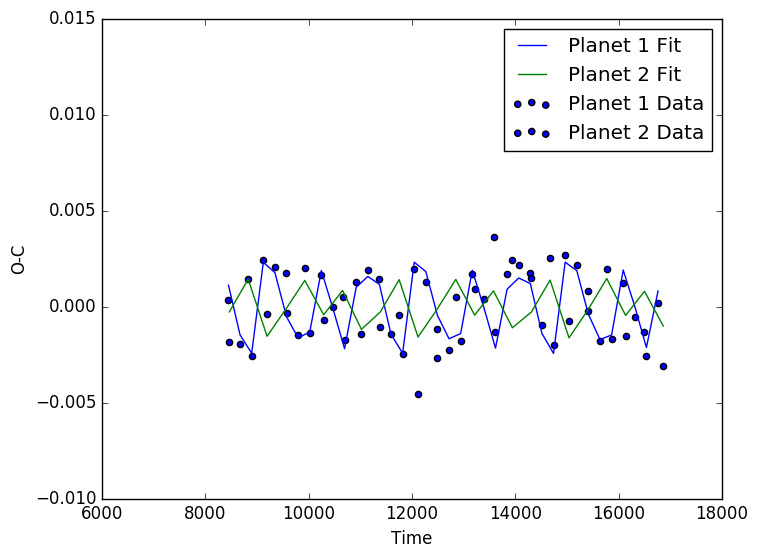

PyObject <matplotlib.legend.Legend object at 0x317e17bd0>

In [22]:
function plot_ttvs(fit::LsqFit.LsqFitResult{Float64},times::Array{Array{Float64}})
    pars = fit.param
    n_p = length(pars[1:5:end])
    n_p_t = length(times)
    plans = TTVFaster.Planet_plane_hk{Float64}[]
    n_trans_arr = make_n_trans(times)
    for i=1:n_p
        push!(plans,make_plane(pars[1+5*(i-1)],pars[2+5*(i-1)],pars[3+5*(i-1)],pars[4+5*(i-1)],pars[5+5*(i-1)]))
    end
    regs,ttvs,trans_times = compute_ttv_pairs(n_p,n_trans_arr,10,plans)
    for i=1:n_p
        if i<=n_p_t
            scatter(times[i],times[i]-regs[i],label="Planet $i Data")
        end
        plot(regs[i],ttvs[i],label="Planet $i Fit")
    end
    xlabel("Time")
    ylabel("O-C")
    legend(loc=0)
end
plot_ttvs(result,data)

#### The best fit TTVs are directly out of phase, while we know they shouldn't look like that; this is also a pretty poor fit to the data. Perhaps there is a 3rd planet!


### 3. Add in a third (non-transiting) planet to your model.  Make a grid in period, and optimize the fit over periods from 500-10,000 days & over ~10 phases for each period.  Plot the maximum likelihood versus period. Note 3: you’ll need to create a wrapper for curve_fit which allows the 3rd period to be fixed.

### Lets edit our model such that we can account for asking for extra planets

In [33]:
function curve_fit_nt(xdata::Array{Array{Float64}},ydata::Array{Float64},weights::Array{Float64},p0::Array{Float64},t0::Float64,P::Float64)
    
    function ttv_model_non_trans(times::Array{Array{Float64}},p::Array{Float64})

        #splice!(p,length(p)-1,[P,t0,p[end-1]]) #push in the period and phase of our planet

        n_p = length(times)+1
        n_trans_arr = make_n_trans(times)
        n_p_t = length(n_trans_arr)
        
        
        #Make planets
        planes = TTVFaster.Planet_plane_hk{Float64}[make_plane(p[1+5*(i-1)],p[2+5*(i-1)],p[3+5*(i-1)],p[4+5*(i-1)],p[5+5*(i-1)]) for i=1:n_p_t]
        push!(planes,make_plane(p[1+5*(n_p-1)],P,t0,p[2+5*(n_p-1)],p[3+5*(n_p-1)]))

        #Compute TTVs
        regs,ttvs,trans_times = compute_ttv_pairs(n_p,n_trans_arr,10,planes)

        #Output linear array of transit times
        lin_out = Float64[]
        for i=1:n_p_t
            append!(lin_out,trans_times[i])
        end

        return lin_out #regular transits plus the TTVS

    end
    
    return curve_fit(ttv_model_non_trans,xdata,ydata,weights,p0),ttv_model_non_trans
    
end

curve_fit_nt (generic function with 1 method)

In [46]:
function fit_ttv_non_trans(dat::Array{Array{Float64}};n_p::Int64 = length(dat)+1)

    P_grid = logspace(log10(500),4)
    phase_grid = collect(0.0:10:0.9)

    P_best = 0.0
    t0_best = 0.0
    fit_best = Float64[]
    chi_best = 1.0e100
    mod_best::Function = () -> ()

    lintimes = Float64[]
    for i=1:(n_p-1)
        append!(lintimes,dat[i])
    end

    weights = [1.0/(0.000347222^2.0) for i=1:length(lintimes)] #30 second precision

    p0 = zeros(5*(n_p-1))
    #initialize params
    #p[1]-p[5] = mass_ratio, period, t0, ecosw, esinw, first planet
    #p[6] - p[10] = same params but second planet
    for i=1:(n_p-1)
        p0[1+5*(i-1)] = 2.0e-6
        p0[2+5*(i-1)] = p_guesser(dat[i])
        p0[3+5*(i-1)] = dat[i][1]
        p0[4+5*(i-1)] = 0.1
        p0[5+5*(i-1)] = 0.1
    end
    
    append!(p0,[2.0e-6,0.1,0.1])
    

    for P in P_grid

        for phase in phase_grid

            t0 = phase*P

            (fit,modl) = curve_fit_nt(dat, lintimes, weights, p0, t0, P)
            
            chi2 = sum((fit.resid.^2).*weights)
            p0 = fit.param #best fit params to feed into the next iteration, should be a bit quicker
            
            if chi2 < chi_best
                chi_best = chi2
                P_best = P
                t0_best = t0
                fit_best = fit
                mod_best = modl
            end
            
        end
    end
    return fit_best,P_best,t0_best,mod_best
end

fit_ttv_non_trans (generic function with 1 method)

In [47]:
fit,P,t0,modl = fit_ttv_non_trans(data) ;

In [49]:
parnames = ["M_1","P_1","t0_1","ecosw_1","esinw_1","M_2","P_2","t0_2","ecosw_2","esinw_2","M_3","P_3","t0_3","ecosw_3","esinw_3"]
splice!(fit.param,length(fit.param)-1,[P,t0,fit.param[end-1]])
for (nam,par) in zip(parnames,fit.param)
    println("$nam = $par")
end
#This looks Jupiter-like, from the period; but the rest of the parameters are unphysical! Let's do MCMC to find better ones.

M_1 = 2.6476121486692508e-6
P_1 = 224.70078476904686
t0_1 = 8445.499215073849
ecosw_1 = 0.037104471102411246
esinw_1 = 0.007649075589200021
M_2 = 3.2590909822244243e-6
P_2 = 365.256439326292
t0_2 = 8461.758241414038
ecosw_2 = 0.04249898234958782
esinw_2 = 0.007097082255350571
M_3 = 8.312570713613962e-10
P_3 = 4516.7783243131125
t0_3 = 0.0
ecosw_3 = 4516.7783243131125
esinw_3 = 0.0


# To Do:
## √1. Clean up code. We use times as a variable like twelve times. 
## √2. Test all of the components of the code thus far, make sure they behave the way we want them too
## √3. Get the 3rd planet fitter working (test every line of fit_ttv_non_trans)
## 4. Start the MCMC fitter running; shouldn't be too hard
###     a. Define ttv_model_mcmc, which can include a non-transiting planet, but the period is a free parameter
###     b. Get each component working. Define a plog object, get init_walkers working, etc. See mc_julia.ipynb

In [60]:
data2d = Array[data,vcat(t1,t2),[0.000347222 for i=1:length(vcat(t1,t2))]]
#^^^^ won't work with mc_julia, because mc_julia needs a 3XN array, so data[:,1] is x, data[:,2] is y, data[:,3] is z
#we'll probably need to mess with our transit model accordingly to figure it out
#ttv_mc = ploglike()

3-element Array{Array{T,N},1}:
 Array{Float64,N}[[8445.5,8670.2,8894.9,9119.6,9344.3,9569.0,9793.7,10018.4,10243.1,10467.8  …  14737.1,14961.8,15186.5,15411.2,15635.9,15860.6,16085.3,16310.0,16534.7,16759.4],[8461.76,8827.02,9192.27,9557.53,9922.79,10288.0,10653.3,11018.6,11383.8,11749.1  …  13575.4,13940.6,14305.9,14671.1,15036.4,15401.6,15766.9,16132.1,16497.4,16862.7]]
 [8445.5,8670.2,8894.9,9119.6,9344.3,9569.0,9793.7,10018.4,10243.1,10467.8  …  13575.4,13940.6,14305.9,14671.1,15036.4,15401.6,15766.9,16132.1,16497.4,16862.7]                                                                                                                                                                                        
 [0.000347222,0.000347222,0.000347222,0.000347222,0.000347222,0.000347222,0.000347222,0.000347222,0.000347222,0.000347222  …  0.000347222,0.000347222,0.000347222,0.000347222,0.000347222,0.000347222,0.000347222,0.000347222,0.000347222,0.000347222]                                   